In [238]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [239]:
df = pd.read_csv('merged_data.csv')
df.head()

,Unnamed: 0,DATE,Total Power (max),Total Power (min),Total Power (avg),Total Power (samp),Total Power (trimmed),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,...,FG,FZ,GS,HZ,MI,PL,RA,SN,TS,VCTS
0,0,2019-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,9.0,17.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-03-01 01:00:00,0.0,0.0,0.0,0.0,0.0,9.0,17.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-03-01 02:00:00,0.0,0.0,0.0,0.0,0.0,9.0,17.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-03-01 03:00:00,0.0,0.0,0.0,0.0,0.0,10.0,19.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-03-01 04:00:00,0.0,0.0,0.0,0.0,0.0,8.0,16.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
## Selecting columns of interest to us.
filtered_cols = [
    'DATE',
    'Total Power (trimmed)',
    'HourlyDryBulbTemperature',
    'HourlyWetBulbTemperature'
]

## Making a new dataframe only with these columns of interest.
hourly = df[filtered_cols]
#hourly['DATE'] = hourly['DATE'].astype(str)

In [241]:
hourly["DATE"] = hourly.apply(lambda x: pd.Timestamp(x["DATE"]), axis=1)

colList = hourly.copy().columns[:-1] 

groupby = hourly

C:\Users\Wade\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [242]:
## Add h-1 to h-n and h+1 to h+24, current time, DoW, and month
# max power, avg power?, dry bulb temp, humidity
# Row: h0 power, h0 weather, h- power, h- weather, h+ weather, (h+ power) together
# features should be built on information from the last several hours

def windowData(df, npast=0, nfuture=0, colpast=[], colfuture=[]):
    # init return variable
    
    # add past windows
    kept_past = df[colpast]  # elements used past windows
    for i in range(1,npast+1):
        temp = kept_past.shift(i)
        temp.columns = [f"{c}-{i}hr" for c in kept_past.columns]
        df = pd.concat([df,temp],axis=1)
        
    # add future windows
    kept_future = df[colfuture]  # elements used future windows
    for i in range(1,nfuture+1):
        temp = kept_future.shift(-i)
        temp.columns = [f"{c}+{i}hr" for c in kept_future.columns]
        df = pd.concat([df,temp],axis=1)
    return df


In [243]:
## Adding TS features (later)

#Adding day of week, day of year, time of day measures
## ** I think these are categorical and should be represented as dummy variables **
## implemented with cyclicality represented by sin and cos
def addTimeFeatures(df):
    months = df.apply(lambda x: x["DATE"].month, axis=1)
    df['month_sin'] = np.sin((months-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((months-1)*(2.*np.pi/12))

    dow = df.apply(lambda x: x["DATE"].dayofweek, axis=1)
    df['DoW_sin'] = np.sin(dow*(2.*np.pi/7))
    df['DoW_cos'] = np.cos(dow*(2.*np.pi/7))

    hr = df.apply(lambda x: x["DATE"].hour, axis=1)
    df['Hour_sin'] = np.sin(hr*(2.*np.pi/24))
    df['Hour_cos'] = np.cos(hr*(2.*np.pi/24))


In [342]:
def genTSfeats(windowedDF, windows = []): # Elements of windows should be greater than one!

    for win in windows: # Loop over windows of different sizes.

        # Generate temporary 'lookback' dataframes for feature construction.
        tmp_power = windowedDF.iloc[:, 4:(3*win)+4:3]
        tmp_drybulb = windowedDF.iloc[:, 5:(3*win)+5:3]
        tmp_wetbulb = windowedDF.iloc[:, 6:(3*win)+6:3]

        tmp_dfs = [tmp_power, tmp_drybulb, tmp_wetbulb]
        var_names = ['power', 'drybulb', 'wetbulb']

        # Loop over temporary dataframes and construct desired features.
        for tmp, var in zip(tmp_dfs, var_names):
            # General statistics for base level.
            windowedDF[f'meanprev{win}_{var}'] = tmp.mean(axis=1)
            windowedDF[f'medianprev{win}_{var}'] = tmp.median(axis=1)
            windowedDF[f'minprev{win}_{var}'] = tmp.min(axis=1)
            windowedDF[f'maxprev{win}_{var}'] = tmp.max(axis=1)
            windowedDF[f'stdprev{win}_{var}'] = tmp.std(axis=1)

            # Capturing trend.
            windowedDF[f'mean_ewmprev{win}_{var}'] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1)
            windowedDF[f'last_ewmprev{win}_{var}'] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]

            windowedDF[f'avgdiff{win}_{var}'] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
            #windowedDF[f'avgdiv{win}_{var}'] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

    return windowedDF

In [385]:
past_features = ['Total Power (trimmed)', 'HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']
future_features = ['HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']

hourlyWindowed = windowData(hourly, npast=24, nfuture=12, colpast=past_features, colfuture=future_features)
genTSfeats(windowedDF=hourlyWindowed, windows = [22])  # [4,7,14,22]
addTimeFeatures(hourlyWindowed)


In [386]:
def genXY(X, target_var, maxoffset=1):
    '''
    Generate X and Y data to be used in run model. X should be untrimmed (include NaNs).
    
    Will return tuple contianing trimmed X and list of Y vectors with offset ranging from 1 to maxoffset.
    '''
    df = X.copy()
    Y = []
    
    for l in range(1,maxoffset+1):
        df[f"offset_{l}"] = df[target_var].shift(-l)
    
    df = df.dropna()
    df = df.reset_index(drop=True)
    df = df.drop(columns=['DATE'])
    
    for l in range(1,maxoffset+1):
        Y.append(df[f"offset_{l}"])
        df.drop(columns=[f"offset_{l}"], inplace=True)
    
    return (df, Y)

In [387]:
X, Ys = genXY(hourlyWindowed, 'Total Power (trimmed)', maxoffset=12)

In [388]:
## Make and run model
def runModel(X, Y, model, verbose=False):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=12345, shuffle=True)  # create train and test sets

    model.fit(X_train, Y_train)  # fit model
    
    # Calculate error metrics
    rsq = model.score(X_test, Y_test)
    rmse = math.sqrt(metrics.mean_squared_error(Y_test, model.predict(X_test)))
    mae = metrics.mean_absolute_error(Y_test, model.predict(X_test))
    
    # Display if selected in arguments
    if verbose:
        print("R Squared Score: {:.4f}".format(rsq))
        print("Root Mean Squared Error: {:.2f}".format(rmse))
        print("Mean Absolute Error: {:.2f}".format(mae))

    #importance = pd.DataFrame({'col_name': rf.feature_importances_}, index=X.columns).sort_values(by='col_name', ascending=False)
    #importance['col_name'] = 100*importance['col_name']
    #print(importance[:10])
    
    return model, mae, rmse, rsq

In [352]:
runModel(X=X, Y=Ys[0], model=ExtraTreesRegressor(), verbose=True)

R Squared Score: 0.9974
Root Mean Squared Error: 290.88
Mean Absolute Error: 147.18


(ExtraTreesRegressor(),
 147.17879441899993,
 290.880049377853,
 0.9974071954458472)

In [204]:
def pltErrors(errorDict,model=""):
    plt.plot(errorDict['ndays'], errorDict['MAE'])
    plt.plot(errorDict['ndays'], errorDict['RMSE'])
    
    plt.legend(['MAE', 'RMSE'])
    plt.xlabel('Hours in the future')
    plt.ylabel('Model Error')
    plt.title(f'Future Prediction Error {model}')
    plt.ylim(ymin=0, ymax=3000)
    xint = range(min(errorDict['ndays']), math.ceil(max(errorDict['ndays']))+1)
    plt.xticks(xint)
    
    plt.show()

In [218]:
def testErrors(X, Ys, model, verbose=False):
    errors = {'ndays':list(range(1,len(Ys)+1)),'MAE':[], 'RMSE':[], 'RSQ':[]}
    for Y in Ys:
        _, mae, rmse, rsq = runModel(X, Y, model)
        errors['MAE'].append(mae)
        errors['RMSE'].append(rmse)
        errors['RSQ'].append(rsq)
        
        
    pltErrors(errors, model)
    if verbose:
        print(f"{model} RMSE {errors['RMSE']}")

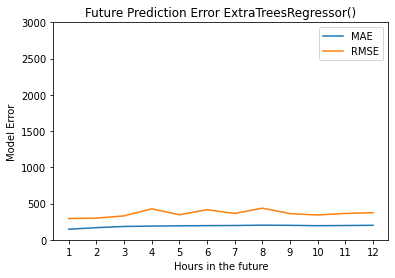

ExtraTreesRegressor() RMSE [292.9124049901438, 299.4862210052199, 329.9025260371595, 427.49339117276753, 345.43872349011855, 415.04955809486825, 363.2535280475202, 436.77614750795175, 361.3082980081215, 341.9880054682521, 364.0604105692665, 374.1463444200172]


In [384]:
testErrors(X=X, Ys=Ys, model=ExtraTreesRegressor(), verbose=True)

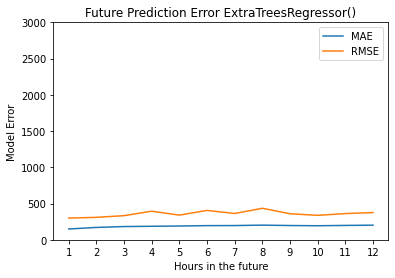

ExtraTreesRegressor() RMSE [299.54487471766055, 309.75986945735417, 333.0836723212764, 394.7363017518924, 340.48977717602713, 405.3337111158211, 362.90181130933803, 434.97715478973623, 359.397659125069, 337.38383106487294, 361.7106053400213, 375.94889375724574]


In [389]:
testErrors(X=X, Ys=Ys, model=ExtraTreesRegressor(), verbose=True)

In [360]:
## Test for past window sizehyper parameter
past_features = ['Total Power (trimmed)', 'HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']
future_features = ['HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']

all_rmse = []
test_sizes = [12,24,36]
for size in test_sizes:
    hourlyWindowed = windowData(hourly, npast=size, nfuture=12, colpast=past_features, colfuture=future_features)
    #genTSfeats(windowedDF=hourlyWindowed, windows = [2,5,12])
    addTimeFeatures(hourlyWindowed)
    
    X, Ys = genXY(hourlyWindowed, 'Total Power (trimmed)', maxoffset=12)
    
    size_rmse = []
    for Y in Ys:
        _, mae, rmse, rsq = runModel(X, Y, model=ExtraTreesRegressor())
        size_rmse.append(rmse)
    all_rmse.append(size_rmse)

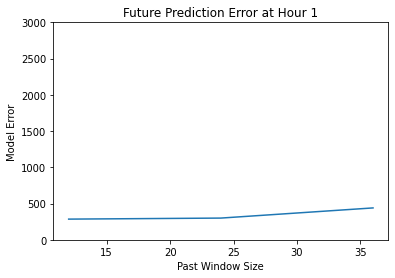

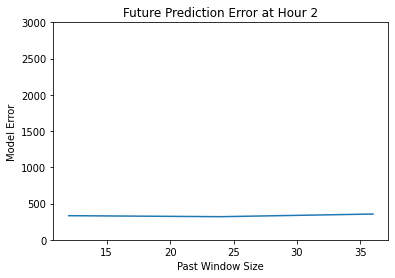

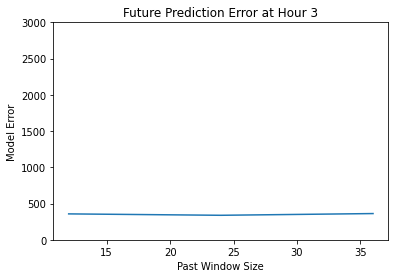

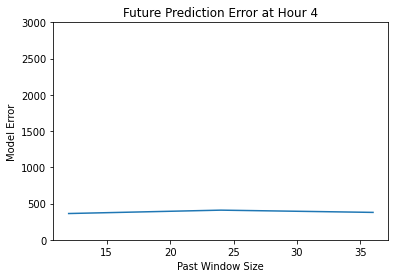

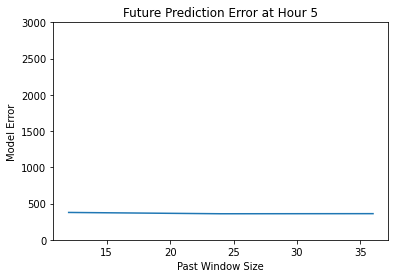

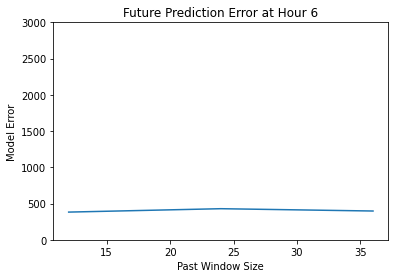

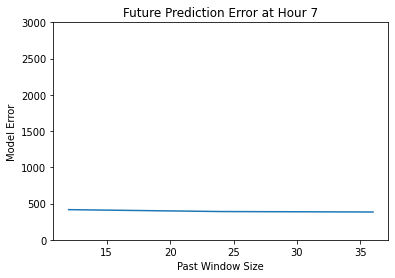

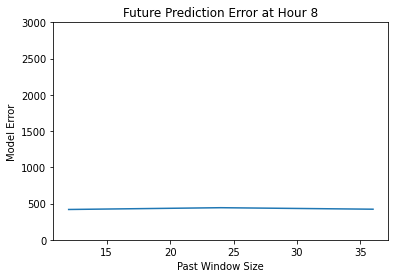

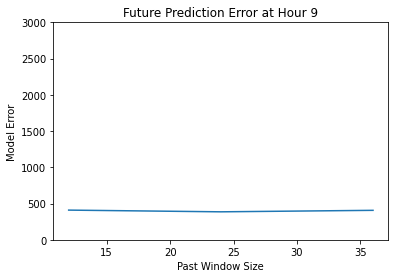

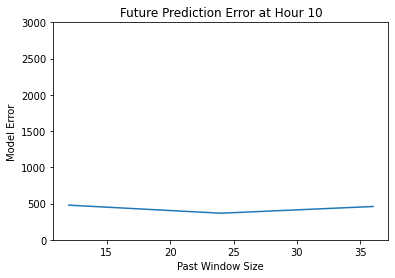

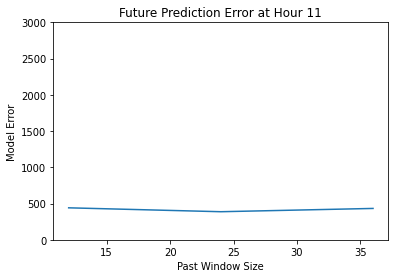

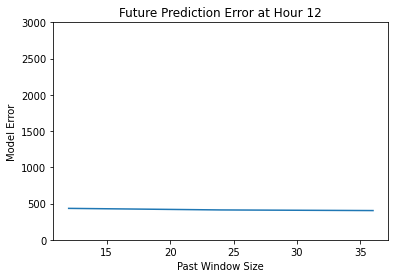

In [370]:
for i in range(12):
    plt.plot(test_sizes, [x[i] for x in all_rmse])
    
    plt.xlabel('Past Window Size')
    plt.ylabel('Model Error')
    plt.title(f'Future Prediction Error at Hour {i+1}')
    plt.ylim(ymin=0, ymax=3000)
    
    plt.show()

In [372]:
## Test for TS feats window size hyperparameter
past_features = ['Total Power (trimmed)', 'HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']
future_features = ['HourlyDryBulbTemperature', 'HourlyWetBulbTemperature']

all_rmse = []
test_sizes = list(range(2,24))
for size in test_sizes:
    hourlyWindowed = windowData(hourly, npast=24, nfuture=12, colpast=past_features, colfuture=future_features)
    genTSfeats(windowedDF=hourlyWindowed, windows = [size])
    addTimeFeatures(hourlyWindowed)
    
    X, Ys = genXY(hourlyWindowed, 'Total Power (trimmed)', maxoffset=12)
    
    size_rmse = []
    for Y in Ys:
        _, mae, rmse, rsq = runModel(X, Y, model=ExtraTreesRegressor())
        size_rmse.append(rmse)
    all_rmse.append(size_rmse)

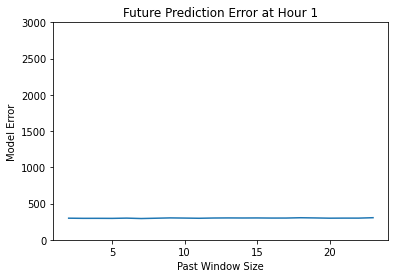

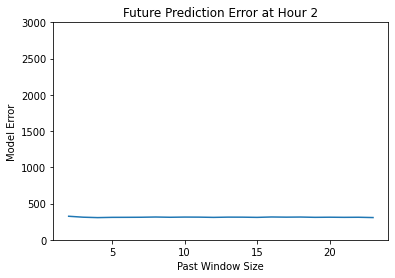

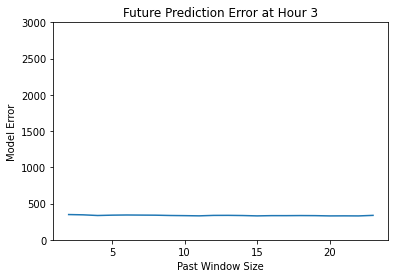

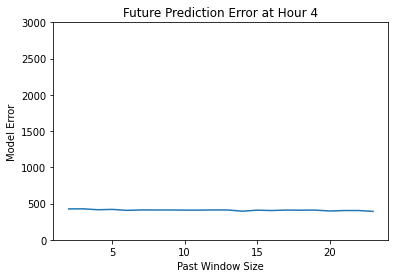

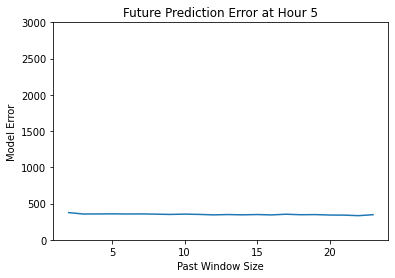

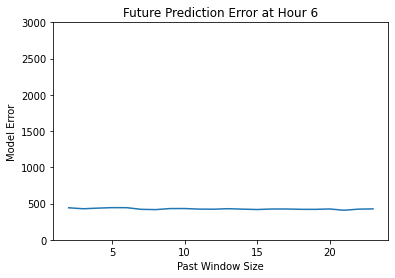

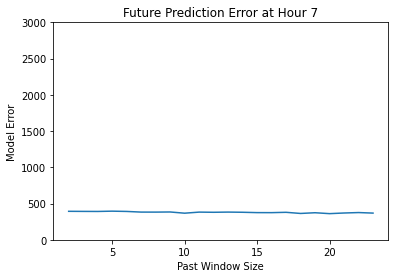

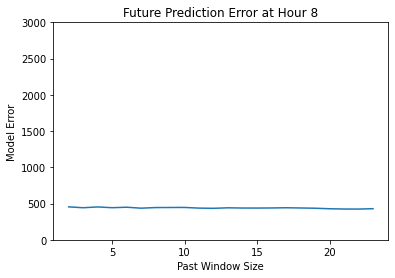

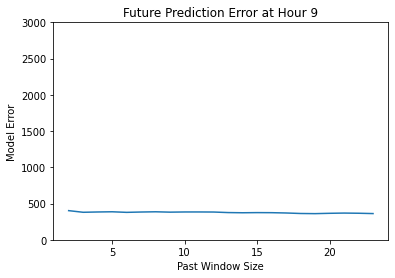

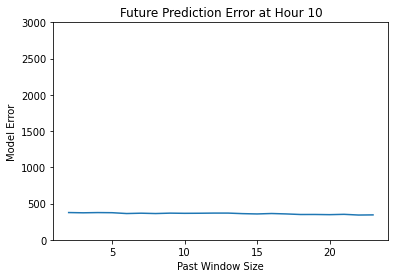

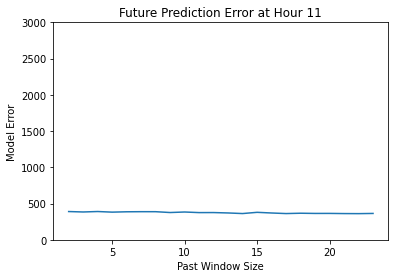

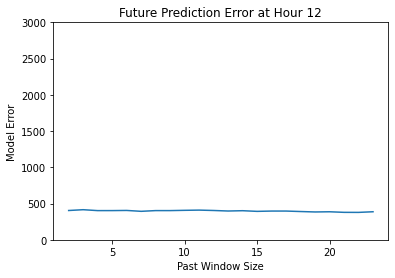

In [373]:
for i in range(12):
    plt.plot(test_sizes, [x[i] for x in all_rmse])
    
    plt.xlabel('Past Window Size')
    plt.ylabel('Model Error')
    plt.title(f'Future Prediction Error at Hour {i+1}')
    plt.ylim(ymin=0, ymax=3000)
    
    plt.show()

In [379]:
disp = 2
for row in all_rmse:
    print(f"{disp}:{sum(row)/len(row)}")
    disp = disp+1

2:386.11506237103566
3:379.1474199492098
4:378.5671687327637
5:379.14846944464176
6:377.5086868095253
7:373.74360216639576
8:374.9757192852062
9:374.88272161128015
10:374.5541587669484
11:373.1594136578771
12:372.5661682796271
13:372.9545967630716
14:368.78184088862537
15:369.35769938287325
16:369.74604854741125
17:370.06747180680554
18:366.54532750823006
19:365.83542893178463
20:363.0535630741865
21:362.2130284780849
22:362.1966382129044
23:363.9838205284252


In [ ]:
4, 7, 14, 22